In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Set paths - Updated for three-class dataset
base_dir = '/content/drive/MyDrive/biotech/Retina_Lab/VGG_next_level'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Set paths - Updated for three-class dataset
base_dir = '/content/drive/MyDrive/biotech/Retina_Lab/VGG_next_level'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Set parameters
img_width, img_height = 224, 224  # VGG16 expects 224x224 input
batch_size = 32
epochs = 20
learning_rate = 1e-4  # Lower learning rate for fine-tuning


In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for testing data
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data
)

# Get class information
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_generator.class_indices}")

Found 2302 images belonging to 3 classes.
Found 585 images belonging to 3 classes.
Number of classes: 3
Class indices: {'cbc': 0, 'pr': 1, 'rbc': 2}


In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze most of the layers
for layer in base_model.layers[:-4]:  # Freeze all but the last 4 convolutional layers
    layer.trainable = False

# Print layer trainability status
for i, layer in enumerate(base_model.layers):
    print(f"{i}: {layer.name} - Trainable: {layer.trainable}")

# Add custom classification layers for 3 classes
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
x = Dense(num_classes, activation='softmax')(x)  # num_classes will be 3

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
0: input_layer - Trainable: False
1: block1_conv1 - Trainable: False
2: block1_conv2 - Trainable: False
3: block1_pool - Trainable: False
4: block2_conv1 - Trainable: False
5: block2_conv2 - Trainable: False
6: block2_pool - Trainable: False
7: block3_conv1 - Trainable: False
8: block3_conv2 - Trainable: False
9: block3_conv3 - Trainable: False
10: block3_pool - Trainable: False
11: block4_conv1 - Trainable: False
12: block4_conv2 - Trainable: False
13: block4_conv3 - Trainable: False
14: block4_pool - Trainable: False
15: block5_conv1 - Trainable: True
16: block5_conv2 - Trainable: True
17: block5_conv3 - Trainable: True
18: block5_pool - Trainable: True


In [ ]:
# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks with updated save path
checkpoint = ModelCheckpoint(
    os.path.join(base_dir, 'best_mod_inl.h5'),  # Updated filename as requested
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7166 - loss: 0.7774
Epoch 1: val_accuracy improved from -inf to 0.88368, saving model to /content/drive/MyDrive/biotech/Retina_Lab/VGG_next_level/best_mod_inl.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 527s 7s/step - accuracy: 0.7175 - loss: 0.7744 - val_accuracy: 0.8837 - val_loss: 0.3044
Epoch 2/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.8438 - loss: 0.3206

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.88368
71/71 ━━━━━━━━━━━━━━━━━━━━ 57s 812ms/step - accuracy: 0.8438 - loss: 0.3206 - val_accuracy: 0.8785 - val_loss: 0.2981
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8630 - loss: 0.3225
Epoch 3: val_accuracy did not improve from 0.88368
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 579ms/step - accuracy: 0.8631 - loss: 0.3224 - val_accuracy: 0.8767 - val_loss: 0.2604
Epoch 4/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.7500 - loss: 0.4645
Epoch 4: val_accuracy did not improve from 0.88368
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7500 - loss: 0.4645 - val_accuracy: 0.8802 - val_loss: 0.2578
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.8732 - loss: 0.3024
Epoch 5: val_accuracy did not improve from 0.88368
71/71 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8731 - loss: 0.3024 - val_accuracy: 0.8819 - val_loss: 0.2569
Epoch 6/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.84

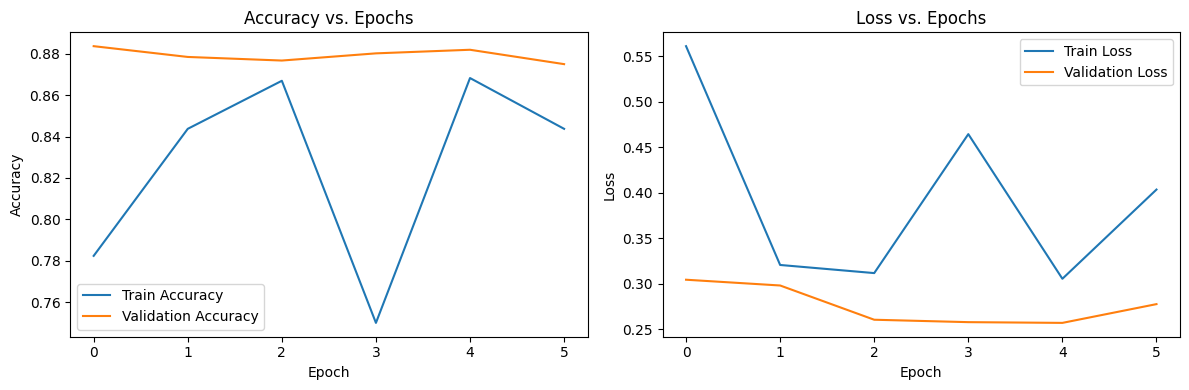

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model for evaluation
model.load_weights(os.path.join(base_dir, 'best_mod_inl.h5'))

# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes[:len(predicted_classes)]

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Print confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step

Classification Report:
              precision    recall  f1-score   support

         cbc       0.67      0.92      0.77       133
          pr       0.96      0.99      0.97       391
         rbc       1.00      0.02      0.03        61

    accuracy                           0.87       585
   macro avg       0.88      0.64      0.59       585
weighted avg       0.90      0.87      0.83       585


Confusion Matrix:
[[122  11   0]
 [  5 386   0]
 [ 55   5   1]]


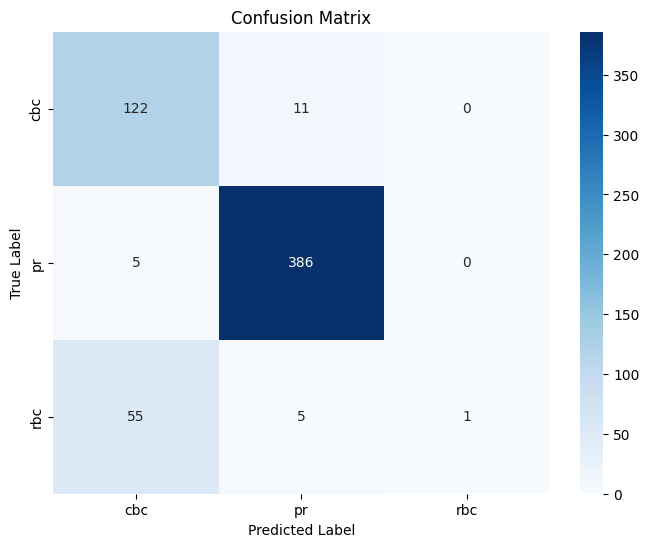

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix nicely with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
